1
/questions/1100644/kubernetes-error-creating-pki-assets-certificate-invalid?r=SearchResults
/questions/1025542/unknown-errors-when-upgrading-planning-kubernetes-cluster-upgrade?r=SearchResults
/questions/1010649/setup-jenkins-on-kubernetes-error-403?r=SearchResults
/questions/714702/kubernetes-kube-proxy-iptables-errors?r=SearchResults
/questions/1133385/kubernetes-cluster-with-certificate-authority?r=SearchResults
/questions/1097086/kubernetes-no-errors-when-editing-node-config-but-changes-not-reflected?r=SearchResults
/questions/1075545/cannot-login-to-kubernetes-dashboard-with-userid-404-error?r=SearchResults
/questions/1082631/kubernetes-dashboard-not-reachable-error-404?r=SearchResults
/questions/938603/i-tried-to-join-kubernetes-nodes-with-master-but-it-shows-errors-in-all-3-nodes?r=SearchResults
/questions/809632/is-it-possible-to-rerun-kubernetes-job?r=SearchResults
/questions/890659/error-deploying-neo4j-cluster-on-kubernetes-namespace?r=SearchResults
/questions/1068310/how-

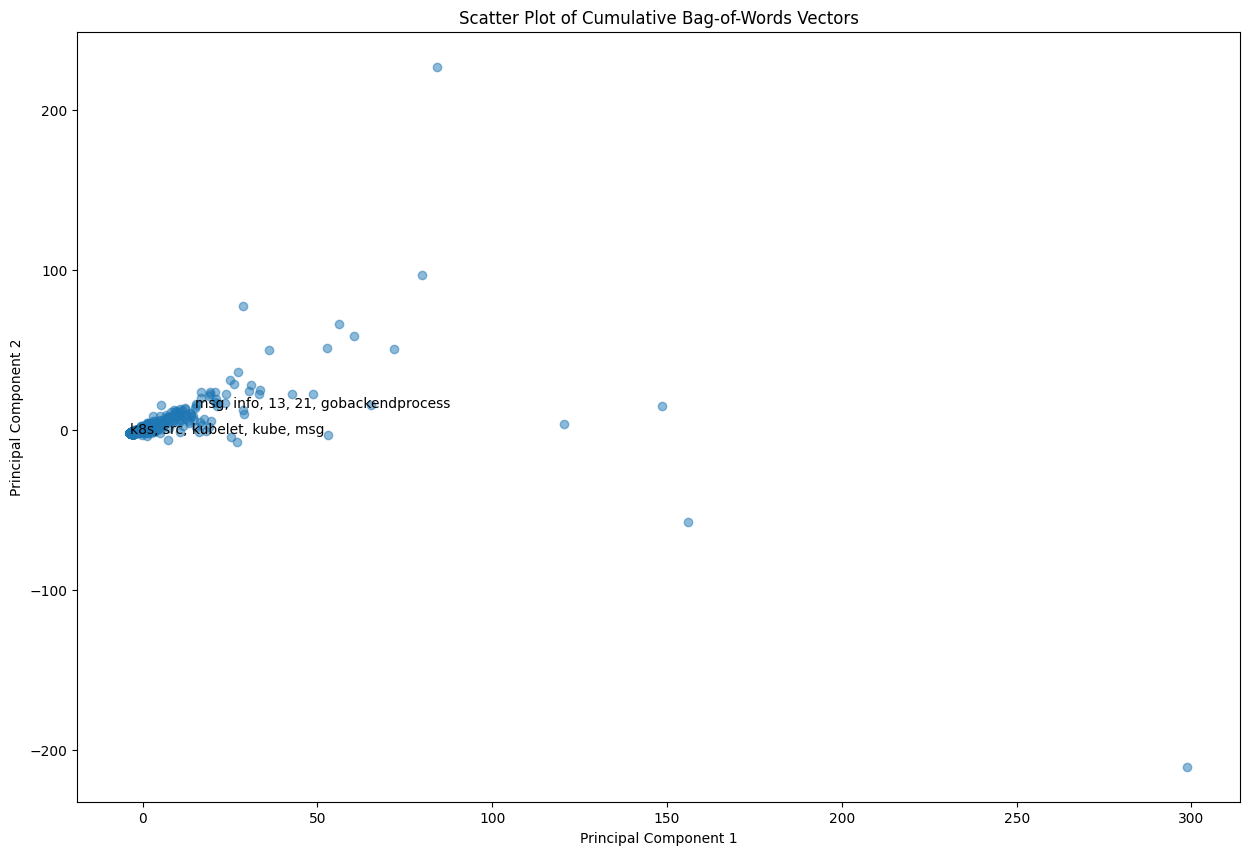

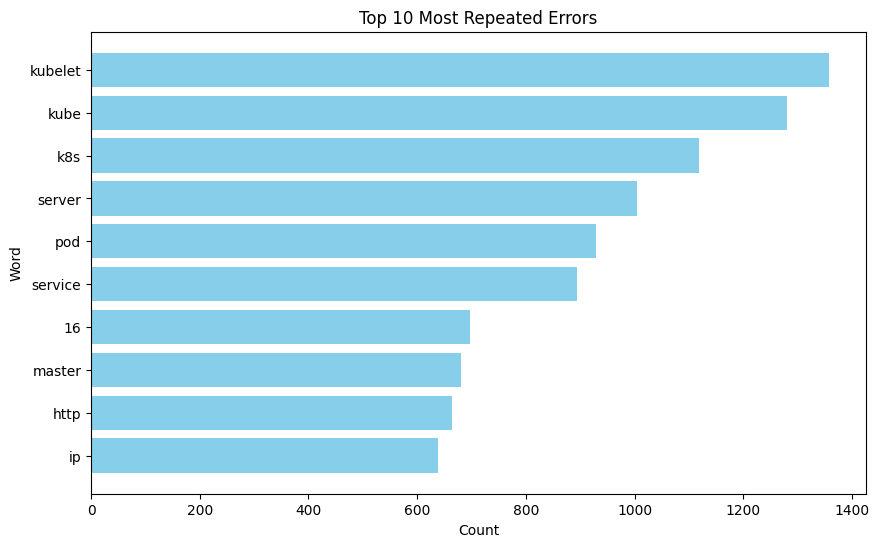

In [4]:
import requests
from bs4 import BeautifulSoup
import spacy
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import numpy as np
import matplotlib.pyplot as plt
import time

nlp = spacy.load('en_core_web_sm')


def create_database():
    conn = sqlite3.connect('stackoverflow_data.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS questions
                 (id INTEGER PRIMARY KEY, title TEXT, body TEXT, entities TEXT)''')
    conn.commit()
    conn.close()

def insert_into_database(title, body, entities):
    conn = sqlite3.connect('stackoverflow_data.db')
    c = conn.cursor()
    c.execute('''INSERT INTO questions (title, body, entities)
                 VALUES (?, ?, ?)''', (title, body, ', '.join(entities)))
    conn.commit()
    conn.close()

def fetch_stackoverflow_page(page_num):
    print(page_num)
    url = f"https://serverfault.com/search?page={page_num}&tab=Relevance&q=kubernetes%20errors"
    response = requests.get(url)
    return response.text

def extract_question_links(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    question_summaries = soup.find_all('div', class_='s-post-summary')
    question_links = []
    for summary in question_summaries:
        try:
            link = summary.find('a', class_='s-link')['href']
            print(link)
            question_links.append(link)
        except TypeError:
            continue  # Skip if link is None
    return question_links

def fetch_question_page_and_extract_details(question_link):
    url = f"https://serverfault.com{question_link}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    title = soup.find('h1', class_='fs-headline1').get_text(strip=True)
    question_body = soup.find('div', class_='question').get_text(strip=True)
    return title, question_body

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

create_database()

custom_stop_words = list(text.ENGLISH_STOP_WORDS) + ['stackoverflow','com','https',
                                                      'failed','running' ,'10', 'question', 'questions',
                                                     'serverfault','kubernetes','error','io','2023',
                                                     'node','cluster','v1']
vectorizer = CountVectorizer(stop_words=custom_stop_words)

question_bodies = []
for page_num in range(1, 40):
    html_content = fetch_stackoverflow_page(page_num)
    question_links = extract_question_links(html_content)

    for question_link in question_links:
        title, question_body = fetch_question_page_and_extract_details(question_link)
        entities = extract_entities(question_body)

        insert_into_database(title, question_body, entities)

        question_bodies.append(question_body)
        error_indices = [i for i in range(len(question_body)) if question_body.lower().startswith('error ', i)]
        for error_index in error_indices:
            error_text = question_body[error_index + len('error '):error_index + len('error ') + 100].strip()
            print(error_text)
            question_bodies.append(error_text)

filtered_question_bodies = [body for body in question_bodies if len(body.split()) > 10]
bow_features = vectorizer.fit_transform(filtered_question_bodies)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
cumulative_bow_features_pca = pca.fit_transform(bow_features.toarray())
component_names = ['Principal Component 1', 'Principal Component 2']
most_important_words = []
for i, component in enumerate(pca.components_):
    word_indices = np.argsort(np.abs(component))[::-1][:5] 
    most_important_words.append([vectorizer.get_feature_names_out()[index] for index in word_indices])

plt.figure(figsize=(15, 10))
plt.scatter(cumulative_bow_features_pca[:, 0], cumulative_bow_features_pca[:, 1], alpha=0.5)

for i, txt in enumerate(most_important_words):
    plt.annotate(', '.join(txt), (cumulative_bow_features_pca[i, 0], cumulative_bow_features_pca[i, 1]))

plt.title('Scatter Plot of Cumulative Bag-of-Words Vectors')
plt.xlabel(component_names[0])
plt.ylabel(component_names[1])


word_counts = bow_features.toarray().sum(axis=0)
feature_names = vectorizer.get_feature_names_out()
sorted_word_counts = sorted(zip(feature_names, word_counts), key=lambda x: x[1], reverse=True)
top_words = [word[0] for word in sorted_word_counts[:10]]
word_counts = [word[1] for word in sorted_word_counts[:10]]

plt.figure(figsize=(10, 6))
plt.barh(top_words, word_counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 10 Most Repeated Errors')
plt.gca().invert_yaxis()
plt.show()
